<a href="https://colab.research.google.com/github/aydawudu/GCP/blob/main/Keras_Sequential_API_Vertex_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
#from google.cloud import aiplatform
import  matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.models import Sequential

print (tf.__version__)
%matplotlib inline

2.8.2


#Using tf.data to read csv files

In [2]:
CSV_COLUMNS = [
    "fare_amount",
    "pickup_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "key",
]
LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], ["na"], [0.0], [0.0], [0.0], [0.0], [0.0], ["na"]]
UNWANTED_COLS = ["pickup_datetime", "key"]


def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data

    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


def create_dataset(pattern, batch_size=1, mode="eval"):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS
    )

    dataset = dataset.map(features_and_labels)

    if mode == "train":
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

#Building a DNN model

In [3]:
INPUT_COLS = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
]

#Input layers of feature columns
feature_coloumns={
    colname: tf.feature_column.numeric_column(colname) for colname in INPUT_COLS
}

In [4]:
#Building a keras DNN model using Sequential
model=Sequential(
    [
        DenseFeatures(feature_columns=feature_coloumns.values()),
        Dense(units=32, activation="relu", name="h1"),
        Dense(units=8, activation="relu", name="h2"),
        Dense(units=1, activation="linear", name="output")

    ]
)

In [5]:
#Creating a custom evaluation metric
def rmse(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_pred-y_true)))

#Compile the model
model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

In [6]:
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern="/content/taxi-train.csv*", batch_size=TRAIN_BATCH_SIZE, mode="train"
)

evalds = create_dataset(
    pattern="/content/taxi-valid.csv*", batch_size=1000, mode="eval"
).take(NUM_EVAL_EXAMPLES // 1000)

In [7]:
# Fit
%time
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

LOGDIR = "./taxi_trained"
history = model.fit(
    x=trainds,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EVALS,
    validation_data=evalds,
    callbacks=[TensorBoard(LOGDIR)],
)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Epoch 1/50


1/1 [==============================] - ETA: 0s - loss: 73.8041 - rmse: 8.5909 - mse: 73.8041

1/1 [==============================] - 18s 18s/step - loss: 73.8041 - rmse: 8.5909 - mse: 73.8041 - val_loss: 101.7674 - val_rmse: 10.0794 - val_mse: 101.7674
Epoch 2/50
1/1 [==============================] - 0s 424ms/step - loss: 76.7719 - rmse: 8.7620 - mse: 76.7719 - val_loss: 99.6080 - val_rmse: 9.9796 - val_mse: 99.6080
Epoch 3/50
1/1 [==============================] - 0s 387ms/step - loss: 86.9883 - rmse: 9.3268 - mse: 86.9883 - val_loss: 99.2315 - val_rmse: 9.9524 - val_mse: 99.2315
Epoch 4/50
1/1 [==============================] - 0s 375ms/step - loss: 77.6093 - rmse: 8.8096 - mse: 77.6093 - val_loss: 98.3305 - val_rmse: 9.9120 - val_mse: 98.3305
Epoch 5/50
1/1 [==============================] - 0s 381ms/step - loss: 76.8973 - rmse: 8.7691 - mse: 76.8973 - val_loss: 98.7301 - val_rmse: 9.9300 - val_mse: 98.7301
Epoch 6/50
1/1 [==============================] - 0s 373ms/step - loss: 78.9292 - rmse: 8.8842 - mse: 78.9292 - val_loss: 98.5749 - val_rmse: 9.9169 - val_mse: 98.5749
E

#Model Evaluation

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features (DenseFeatur  multiple                 0         
 es)                                                             
                                                                 
 h1 (Dense)                  multiple                  192       
                                                                 
 h2 (Dense)                  multiple                  264       
                                                                 
 output (Dense)              multiple                  9         
                                                                 
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


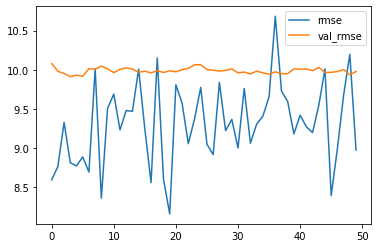

In [10]:
RMSE_COLS=["rmse", "val_rmse"]
pd.DataFrame(history.history)[RMSE_COLS].plot()

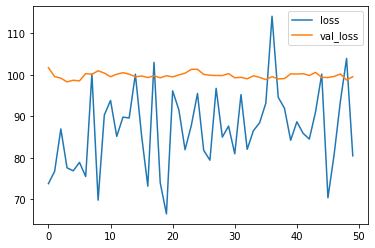

In [11]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot()

#Prediction

In [12]:
model.predict(
    x={
        "pickup_longitude": tf.convert_to_tensor([-73.982683]),
        "pickup_latitude": tf.convert_to_tensor([40.742104]),
        "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
        "dropoff_latitude": tf.convert_to_tensor([40.755174]),
        "passenger_count": tf.convert_to_tensor([3.0]),
    },
    steps=1,
)

array([[11.553261]], dtype=float32)

In [13]:
OUTPUT_DIR="./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
TIMESTAMP=datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH=os.path.join(OUTPUT_DIR, TIMESTAMP)

tf.saved_model.save(model, EXPORT_PATH)

In [14]:
!saved_model_cli show \
    --tag_set serve \
    --signature_def serving_default \
    --dir {EXPORT_PATH}

!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dropoff_latitude:0
  inputs['dropoff_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dropoff_longitude:0
  inputs['passenger_count'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_passenger_count:0
  inputs['pickup_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_pickup_latitude:0
  inputs['pickup_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_pickup_longitude:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict
./export/savedmodel/20220929174520
./export/savedmodel/20220929

#Deploying the model to Vertex AI

In [15]:

PROJECT = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT = PROJECT[0]
BUCKET = PROJECT
REGION = "us-central1"
MODEL_DISPLAYNAME = f"taxifare-kerase-sequential{TIMESTAMP}"

print(f"MODEL_DISPLAYNAME: {MODEL_DISPLAYNAME}")

# from https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest"
)

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

MODEL_DISPLAYNAME: taxifare-kerase-sequential20220929174520


In [24]:
%%bash
# Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket exists, let's not recreate it."
else
    echo "Creating a new GCS bucket."
    gsutil mb -l ${REGION} gs://${BUCKET}
    echo "Here are your current buckets:"
    gsutil ls
fi

Creating a new GCS bucket.
Here are your current buckets:


You are attempting to perform an operation that requires a project id, with none configured. Please re-run gsutil config and make sure to follow the instructions for finding and entering your default project id.
CommandException: "mb" command does not support provider-only URLs.
You are attempting to perform an operation that requires a project id, with none configured. Please re-run gsutil config and make sure to follow the instructions for finding and entering your default project id.


CalledProcessError: ignored

In [17]:
#Bucket exists, let's not recreate it.
!gsutil cp -R $EXPORT_PATH gs://$BUCKET/$MODEL_DISPLAYNAME

InvalidUrlError: Cloud URL scheme should be followed by colon and two slashes: "://". Found: "gs:///taxifare-kerase-sequential20220929174520".


In [18]:
uploaded_model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAYNAME,
    artifact_uri=f"gs://{BUCKET}/{MODEL_DISPLAYNAME}",
    serving_container_image_uri=SERVING_CONTAINER_IMAGE_URI,
)

NameError: ignored

In [19]:
MACHINE_TYPE = "n1-standard-2"

endpoint = uploaded_model.deploy(
    machine_type=MACHINE_TYPE,
    accelerator_type=None,
    accelerator_count=None,
)

NameError: ignored

In [21]:

instance = {
    "pickup_longitude": -73.982683,
    "pickup_latitude": 40.742104,
    "dropoff_longitude": -73.983766,
    "dropoff_latitude": 40.755174,
    "passenger_count": 3.0,
}
endpoint.predict([instance])

NameError: ignored

#Cleanup

In [22]:
endpoint.undeploy_all()

NameError: ignored

In [23]:

endpoint.delete()

NameError: ignored